In [1]:
import numpy as np
import h5py
import tensorflow as tf
from keras import Model, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tf_keras_vis.gradcam import GradcamPlusPlus, Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore, BinaryScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib import cm
import json
from scipy.ndimage import zoom

In [19]:
def load_data(path):
    with h5py.File(path, 'r') as f:
        x = f['image'][()]
        y = f['label'][()]
    return np.array(x), np.array(y)

# Set this to none if you will manually input the needed variables
dataJson = r"C:\Users\Michael\Desktop\Model Benchmark\data\CatOrDog\data.json"

# Image dimensions that the model was trained on
# Manually Set This If data.json does not exist, otherwise can leave as None
# input_dimensions = [96, 96, 1]
input_dimensions = None

# Class Names
# Manually Set This If data.json does not exist, otherwise can leave as None
# class_names = ["Cat", "Dog"]
class_names = None

# Number of classes
# Manually Set This If data.json does not exist, otherwise can leave as None
# num_classes = 2
num_classes = None

# Automatically read the input_dimensions, class_names and num_classes from a data.json if it exists
if dataJson is not None:
    with open(dataJson, "r") as f:
        data = json.load(f)

    input_dimensions = data['input_size']
    class_names = data['class_names']
    num_classes = data['num_classes']
    f.close()


x_test, y_test = load_data(r'C:\Users\Michael\Desktop\Model Benchmark\data\CatOrDog\test.h5')

# Normalize data
x_test = x_test.reshape(-1, input_dimensions[0], input_dimensions[1], input_dimensions[2]) / 255.0
#y_test = to_categorical(y_test, num_classes=num_classes)

# Load the best saved model
model = load_model('best_model2.h5')

print(model.summary())

Model: "cat_dog_model_standard"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 

## Create The Gradcam Objects

In [9]:
# Create GradCAM++ object
gradcam_plus_plus = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), clone=True)
# Create GradCam object
gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)
# Create SmoothGrad Object
saliency = Saliency(model,model_modifier=ReplaceToLinear(),clone=True)


## Specify Which Image Indexes to View

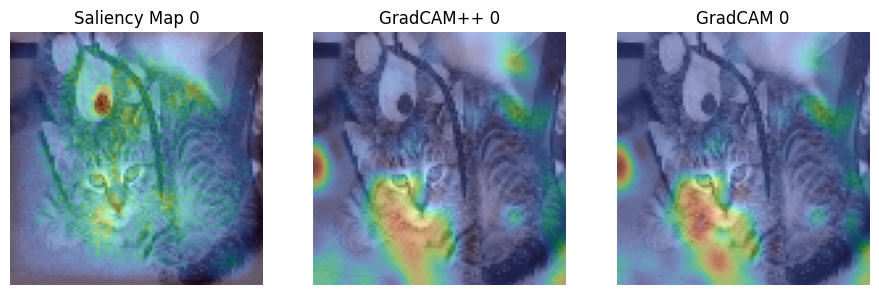

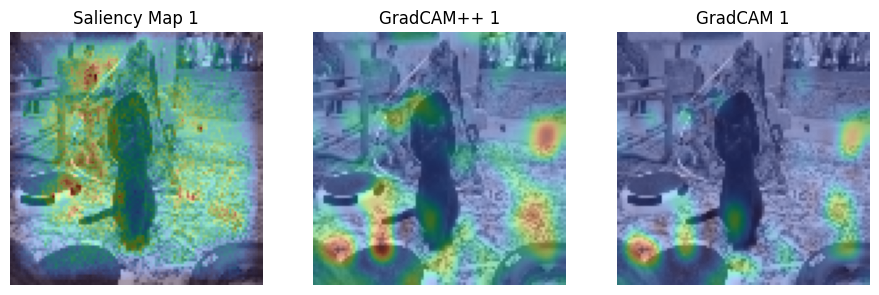

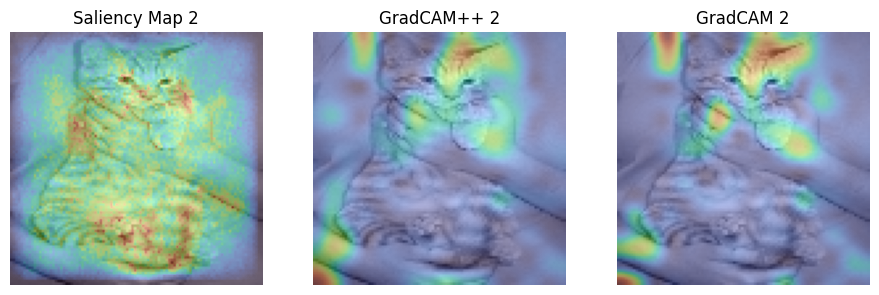

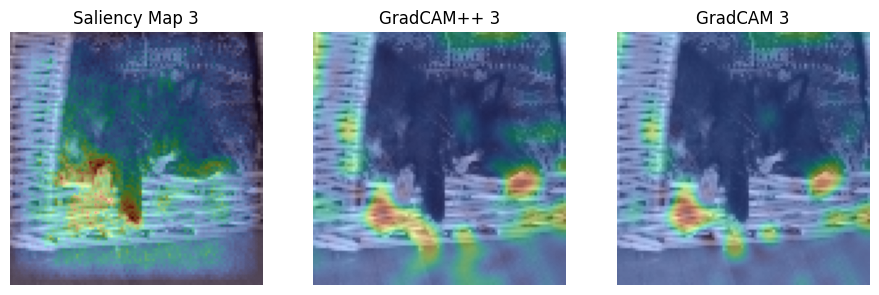

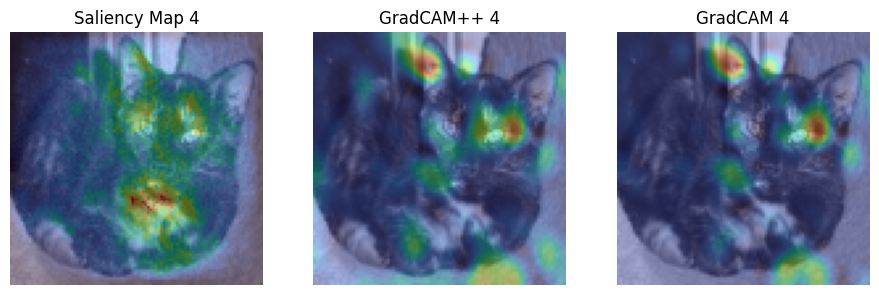

In [22]:
startIndex = 0
endIndex = 5
cmap = "turbo"

# Not sure why CategoricalScore([0,1])  doesnt work as CategoricalScore(0) and CategoricalScore(1) both work and give different outputs
# https://keisen.github.io/tf-keras-vis-docs/api/tf_keras_vis.utils.scores.html

# Loop over the specified range of indices
for index in range(startIndex, endIndex):
    # Calculate saliency map
    saliency_map = saliency(score=CategoricalScore(y_test[index]),
                            seed_input=x_test[index],
                            smooth_samples=50,
                            smooth_noise=0.20,
                            )[0]

    # Calculate GradCAM++
    plus_map = gradcam_plus_plus(CategoricalScore(y_test[index]),
                                 x_test[index],
                                 penultimate_layer=-1,
                                 expand_cam=False)[0]

    # Calculate GradCAM
    gradcam_map = gradcam(CategoricalScore(y_test[index]),
                          x_test[index],
                          penultimate_layer=-1,
                          expand_cam=False)[0]

    # Resize the feature maps to match the input image dimensions
    
    # Normalize saliency map for visualization
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))
    
    scale_factor = (input_dimensions[0] / saliency_map.shape[0], input_dimensions[1] / saliency_map.shape[1])
    saliency_map_resized = zoom(saliency_map, scale_factor)
    
    scale_factor = (input_dimensions[0] / plus_map.shape[0], input_dimensions[1] / plus_map.shape[1])
    plus_map_resized = zoom(plus_map, scale_factor)
    
    scale_factor = (input_dimensions[0] / gradcam_map.shape[0], input_dimensions[1] / gradcam_map.shape[1])
    gradcam_map_resized = zoom(gradcam_map, scale_factor)

    # Plot the original image and overlay the feature maps
    plt.figure(figsize=(15, 5))

    # Saliency Map
    plt.subplot(1, 4, 1)
    plt.imshow(x_test[index], cmap='gray', alpha=1)
    plt.imshow(saliency_map_resized, cmap=cmap, alpha=0.4)
    plt.title(f"Saliency Map")
    plt.axis('off')

    # GradCAM++
    plt.subplot(1, 4, 2)
    plt.imshow(x_test[index], cmap='gray', alpha=1)
    plt.imshow(plus_map_resized, cmap=cmap, alpha=0.4)
    plt.title(f"GradCAM++ {index}")
    plt.axis('off')

    # GradCAM
    plt.subplot(1, 4, 3)
    plt.imshow(x_test[index], cmap='gray', alpha=1)
    plt.imshow(gradcam_map_resized, cmap=cmap, alpha=0.4)
    plt.title(f"GradCAM {index}")
    plt.axis('off')

    # Display the plots
    plt.show()